#### Import libraries and select numpy/cupy

In [1]:
import os
import torch

# numpy is way faster than cupy - sticking with numpy for now
import numpy as cp

import scipy
import matplotlib.pyplot as plt
from scipy import signal


cp.random.seed(42)


#### Define ARMAX class and generate sample data

In [2]:
class ARMAX:
    def __init__(self, A, B, C, F, L):
        self.A = cp.array(A)
        self.B = cp.array(B)
        self.C = cp.array(C)
        self.F = cp.array(F)
        self.L = cp.array(L)
    
    def simulate(self, n_samples, R=None, noise_std=0.1):
        Y = cp.zeros(n_samples)
        U = cp.zeros(n_samples)
        N = cp.random.normal(0, noise_std, n_samples)
        
        if R is None:
            R = cp.zeros(n_samples)
        
        max_order = max(len(self.A), len(self.B), len(self.C), len(self.F), len(self.L))
        
        for t in range(max_order, n_samples):
            Y[t] = (- cp.dot(self.A[1:], Y[t-1:t-len(self.A):-1]) 
                    + cp.dot(self.B, U[t-1:t-len(self.B)-1:-1])
                    + cp.dot(self.C, N[t:t-len(self.C):-1]))
            
            U[t] = (cp.dot(self.L, R[t:t-len(self.L):-1]) 
                    - cp.dot(self.F, Y[t:t-len(self.F):-1]))
        
        return Y, U, N, R
    
    def plot_results(self, Y, U, N, R):
        fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
        
        axs[0].plot(Y)
        axs[0].set_ylabel('Output (Y)')
        axs[0].set_title('ARMAX Closed-Loop Simulation Results')
        
        axs[1].plot(U)
        axs[1].set_ylabel('Input (U)')
        
        axs[2].plot(N)
        axs[2].set_ylabel('Noise (N)')
        
        axs[3].plot(R)
        axs[3].set_ylabel('Reference (R)')
        axs[3].set_xlabel('Time')
        
        plt.tight_layout()
        plt.show()

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ARMAX data gen

A = [1, -0.33]  # A(z^-1) = 1 - 0.33z^-1
B = [0.22]      # B(z^-1) = 0.22z^-1
C = [1, 0.15]   # C(z^-1) = 1 + 0.15z^-1
F = [0.31, 0.23] # F(z^-1) = 0.31 + 0.23z^-1
L = [1]        # L(z^-1) = 1

armax_model = ARMAX(A, B, C, F, L)
n_samples = 100
# R = signal.square(cp.linspace(0, 10*cp.pi, n_samples)) # square wave reference signal
R = cp.sign(cp.sin(cp.linspace(0, 10*cp.pi, n_samples))) # square wave reference signal, works with both cupy and numpy

Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.2)
# armax_model.plot_results(Y, U, N, R)


In [3]:
R

array([ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [4]:
cp.zeros(n_samples)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

#### Define SPS indirect model class and show example usage

In [5]:
from sps_indirect import SPS_indirect_model

In [6]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SPS

A  = [1, -0.33]
B = [0, 0.22]
C = [1, 0.15]

G = (B, A)  
H = (C, A)     
F = ([0.31, 0.23], [1])  
L = ([1], [1])         

m = 100
q = 5
T = n_samples  # Example sample size

# import cProfile, pstats
# profiler = cProfile.Profile()

model = SPS_indirect_model(m, q)
G_0, H_0 = model.transform_to_open_loop(G, H, F, L) # open loop system is Y_t = G_0(z^-1, kappa)U_t + H_0(z^-1, kappa)N_t
in_sps, S1 = model.open_loop_sps(G_0=G_0, H_0=H_0, Y_t=Y, U_t=R, n_a=1, n_b=1)

#### Define functions for evaluating and plotting 1st order SPS confidence region

In [7]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ example of identifying an SPS confidence region

def conf_region_1st_order(a_values, b_values, model, C, L, F, Y, R):

    # Create a meshgrid for a and b values
    a_grid, b_grid = cp.meshgrid(a_values, b_values, indexing='ij')

    # Flatten the grids for iteration
    a_flat = a_grid.ravel()
    b_flat = b_grid.ravel()

    # Store results in a list
    results = []

    # Create torch tensors directly on GPU
    try:
        _ = cp.asnumpy(C)
        device = torch.cuda.current_device()
    except:
        device = None
    a_torch = torch.tensor(a_flat, dtype=torch.float32, device=device)
    b_torch = torch.tensor(b_flat, dtype=torch.float32, device=device)

    # Vectorized operations to minimize Python loops
    A_torch = torch.stack([torch.ones_like(a_torch), -a_torch], dim=-1)
    B_torch = torch.stack([torch.zeros_like(b_torch), b_torch], dim=-1)

    # Perform the operations in batch
    A = cp.from_dlpack(A_torch)
    B = cp.from_dlpack(B_torch)

    # Assuming 'model' is predefined and contains the necessary methods
    for i in range(len(a_flat)):
        G = (B[i], A[i])  # G should be a tuple of arrays
        H = (C, A[i])  # H should be a tuple of arrays

        # Transform to open loop
        G_0, H_0 = model.transform_to_open_loop(G, H, F, L)  # Assuming F and L are defined

        # Check the condition and store the result if true
        in_sps, S1 = model.open_loop_sps(G_0, H_0, Y, R, 1, 1)  # Assuming Y and U are defined
        if in_sps:
            results.append((a_flat[i].item(), b_flat[i].item()))
    # Convert the results to a NumPy array
    results = cp.array(results)
    return results

a_values = cp.arange(0, 0.4, 0.02)
b_values = cp.arange(0, 0.4, 0.02)
results = conf_region_1st_order(a_values, b_values, model, C, L, F, Y, R)

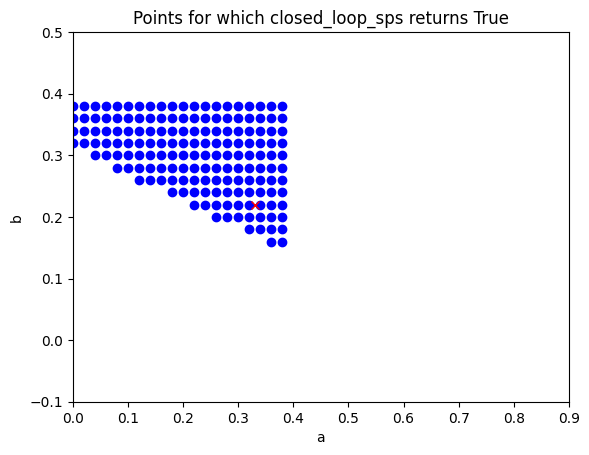

In [8]:
def plot_results(results, true_a=0.33, true_b=0.22):
    fig, ax = plt.subplots()
    
    try:
        results = cp.asnumpy(results)  # convert to np.ndarray
    except AttributeError:
        pass  # already an np.ndarray

    ax.plot(results[:, 0], results[:, 1], 'bo')


    # Labeling the plot
    ax.set_xlabel('a')
    ax.set_ylabel('b')
    # axis limits
    ax.set_xlim([0, 0.9])
    ax.set_ylim([-0.1, 0.5])
    ax.set_title('Points for which closed_loop_sps returns True')

    # Plot the true values
    ax.plot(true_a, true_b, 'rx')  # Plot the true values as a red dot

    # Show the plot
    plt.show()

plot_results(results)

#### Functions for converting G(z) to state space (observer canonical form)

In [9]:
from optimal_controls import tf_to_ocf, tf_list_to_ocf_list

c:\Users\conor\anaconda3\envs\capstone_v2\lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [10]:
tf_to_ocf([0, 0.5, 0.25], [2, 1, 0.5, 0.25])

(array([[ 0.   ,  0.   , -0.125],
        [ 1.   ,  0.   , -0.25 ],
        [ 0.   ,  1.   , -0.5  ]]),
 array([[0.   ],
        [0.125],
        [0.25 ]]),
 array([[0., 0., 1.]]))

#### get_optimal_controller(): testing and examples

In [11]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ testing get_optimal_controller_v()

# convert TF -> SS, using Observer Canonical Form (OCF)
identified_coeffs = [([0, 0.255, 0.58], [1, 0.45, 0.3, 0.2]),
                     ([0, 0.256, 0.56], [1, 0.43, 0.31, 0.23]),
                     ([0, 0.252, 0.52], [1, 0.44, 0.32, 0.25]),
                     ([0, 0.250, 0.58], [1, 0.41, 0.35, 0.19]),
                     ([0, 0.253, 0.53], [1, 0.42, 0.34, 0.21])]
A_in_set, B_in_set = tf_list_to_ocf_list(identified_coeffs)


# ~~~ 2x2 test matrices

A_in_set = cp.array([
        [[0.5, 1], [0, 0.25]], 
        [[0.48, 1], [0, 0.25]],
        [[0.52, 1], [0, 0.25]],
        [[0.54, 1], [0, 0.25]]
    ])

B_in_set = cp.array([
        [[0], [1]],
        [[0], [1]],
        [[0], [1]],
        [[0], [1]]
    ])

In [12]:
from optimal_controls import get_optimal_controller

n = 2
Q = cp.eye(n)
R = cp.eye(1)
x_0 = cp.zeros([n,1])
x_0[0][0] = 1

get_optimal_controller(A_in_set,B_in_set,Q,R,x_0)

array([[0.10985363, 0.37904795]])

#### optimal_control.py: speed tests

In [13]:
from optimal_controls import get_optimal_controller_v_version1
from optimal_controls import get_optimal_controller_v_version2

In [14]:
for i in range(1000):
    get_optimal_controller_v_version1(A_in_set,B_in_set,Q,R,x_0)
get_optimal_controller_v_version1(A_in_set,B_in_set,Q,R,x_0)

array([[0.10985363, 0.37904795]])

In [15]:
for i in range(1000):
    get_optimal_controller_v_version2(A_in_set,B_in_set,Q,R,x_0)
get_optimal_controller_v_version2(A_in_set,B_in_set,Q,R,x_0)

array([[0.10985363, 0.37904795]])

In [16]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ testing dlqr() and dqlr_custom()
from optimal_controls import dlqr, dlqr_custom
A = A_in_set[0,:]
B = B_in_set[0,:]

In [17]:
for i in range(10000):
    K, _ = dlqr(A, B, Q, R)

In [18]:
for i in range(10000):
    K, _ = dlqr_custom(A,B,Q,R,tol=1e-6)

#### Example of first order system adaptive control

In [19]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ pseudo code

k = 0.22 # initial feedback controller

k_vals = []
MSE_vals = []
results_vals = []
a_vals = []

n_iters = 20
param_change_iter = 5

for i in range(n_iters):
# for i in range(11):

    if i >= param_change_iter:
        a = 0.3
    else:
        a = 0.6
    # a = 0.3  + 0.3*(i/n_iters)

    # ~~~~~~~~~~~ run the system, gather input/output data

    # n_samples = 100 + 100*i
    n_samples = 200
    m = 20
    q = 1

    A = [1, -a]      # A(z^-1) = 1 - az^-1
    B = [0.22]          # B(z^-1) = 0.22z^-1
    C = [1, 0.15]       # C(z^-1) = 1 + 0.15z^-1
    F = [k]             # proportional feedback
    L = [1]             # L(z^-1) = 1

    armax_model = ARMAX(A, B, C, F, L)
    
    # if i==0:
    #     R = cp.sign(cp.sin(cp.linspace(0, 10*cp.pi, n_samples)))
    # elif i==1:
    #     # impulse train (approximate, R=epsilon instead of R=0)
    #     R = cp.ones(n_samples) * 1e-6
    #     R[::50] = 1
    # elif i==2:
    #     R = signal.sawtooth(cp.linspace(0, 10*cp.pi, n_samples),width=0)
    # elif i==3:
    #     R = signal.sawtooth(cp.linspace(0, 10*cp.pi, n_samples),width=0)*0.5 + cp.ones(n_samples)*0.5
    # elif i==4:
    #     R = cp.ones(n_samples) * 0.01
    #     R = R ** cp.arange(n_samples)
    # elif i==5:
    #     R = cp.ones(n_samples) * 0.01
    #     R = R ** cp.arange(n_samples)
    # elif i==6:
    #     R = cp.ones(n_samples) * 0.5
    #     R = R ** cp.arange(n_samples)
    # elif i==7:
    #     R = cp.ones(n_samples) * 0.9
    #     R = R ** cp.arange(n_samples)
    # elif i==8:
    #     R = cp.ones(n_samples) * 0.98
    #     R = R ** cp.arange(n_samples)
    # elif i==9:
    #     R = cp.random.randn(n_samples) * 0.0001**2
    # elif i==10:
    #     R = signal.chirp(cp.linspace(0,10,n_samples),f0=0,t1=10*cp.pi,f1=5)

    if i % 2 == 0:
        # square wave
        R = cp.sign(cp.sin(cp.linspace(0, 10*cp.pi, n_samples)))
    else:
        # square wave
        R = cp.sign(cp.sin(cp.linspace(0, 10*cp.pi, n_samples)))
        
        # # impulse train (approximate, R=epsilon instead of R=0)
        # R = cp.ones(n_samples) * 1e-2
        # R[::50] = 1

        # # sawtooth
        # R = signal.sawtooth(cp.linspace(0, 10*cp.pi, n_samples),width=0) + cp.ones(n_samples)

        # exponentially decaying sequence
        # R = cp.ones(n_samples) * 0.9
        # R = R ** cp.arange(n_samples)
        # print('non-square input')


    Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.2)
    MSE = cp.sum((R - Y) ** 2) / n_samples
    MSE_vals.append(MSE)
    # armax_model.plot_results(Y,U,N,R)

    # ~~~~~~~~~~~ create the SPS model object with the current feedback controller

    model = SPS_indirect_model(m, q, n_samples-1)
    # print(model.N)

    A  = [1, -a]
    B = [0, 0.22]
    C = [1, 0.15]

    G = (B, A)  
    H = (C, A)     
    F = ([k], [1])
    L = ([1], [1])         

    G_0, H_0 = model.transform_to_open_loop(G, H, F, L) # open loop system is Y_t = G_0(z^-1, kappa)U_t + H_0(z^-1, kappa)N_t


    # ~~~~~~~~~~~ identify SPS confidence region using indirect SPS

    a_values = cp.arange(0, 1.0, 0.02)
    b_values = cp.arange(0, 0.5, 0.02)
    results = conf_region_1st_order(a_values, b_values, model, C, L, F, Y, R)
    a_in_set = results[:,0]
    b_in_set = results[:,1]

    # ~~~~~~~~~~~ identify the optimal controller

    # A_ss, B_ss, C_ss, D_ss = signal.tf2ss(G[0], G[1]) # change the system representation (transfer function -> state space). NB: ignoring H(z)
    # a_in_set, b_in_set = tf_list_to_ocf_list(cp.array(list(zip(a_values, b_values))))
    k = get_optimal_controller(a_in_set,b_in_set,1,1) # solve the min-max problem - the minimisation is done by solving the DARE, maximisation by brute force (iterate over points in SPS confidence region)
    k_vals.append(k)
    results_vals.append(results)
    a_vals.append(a)
    
    # print("This run's mean squared error (MSE):", MSE)
    # print("New optimal controller:", k)
    # print(i)
    # plot_results(results, true_a=a, true_b=0.22)


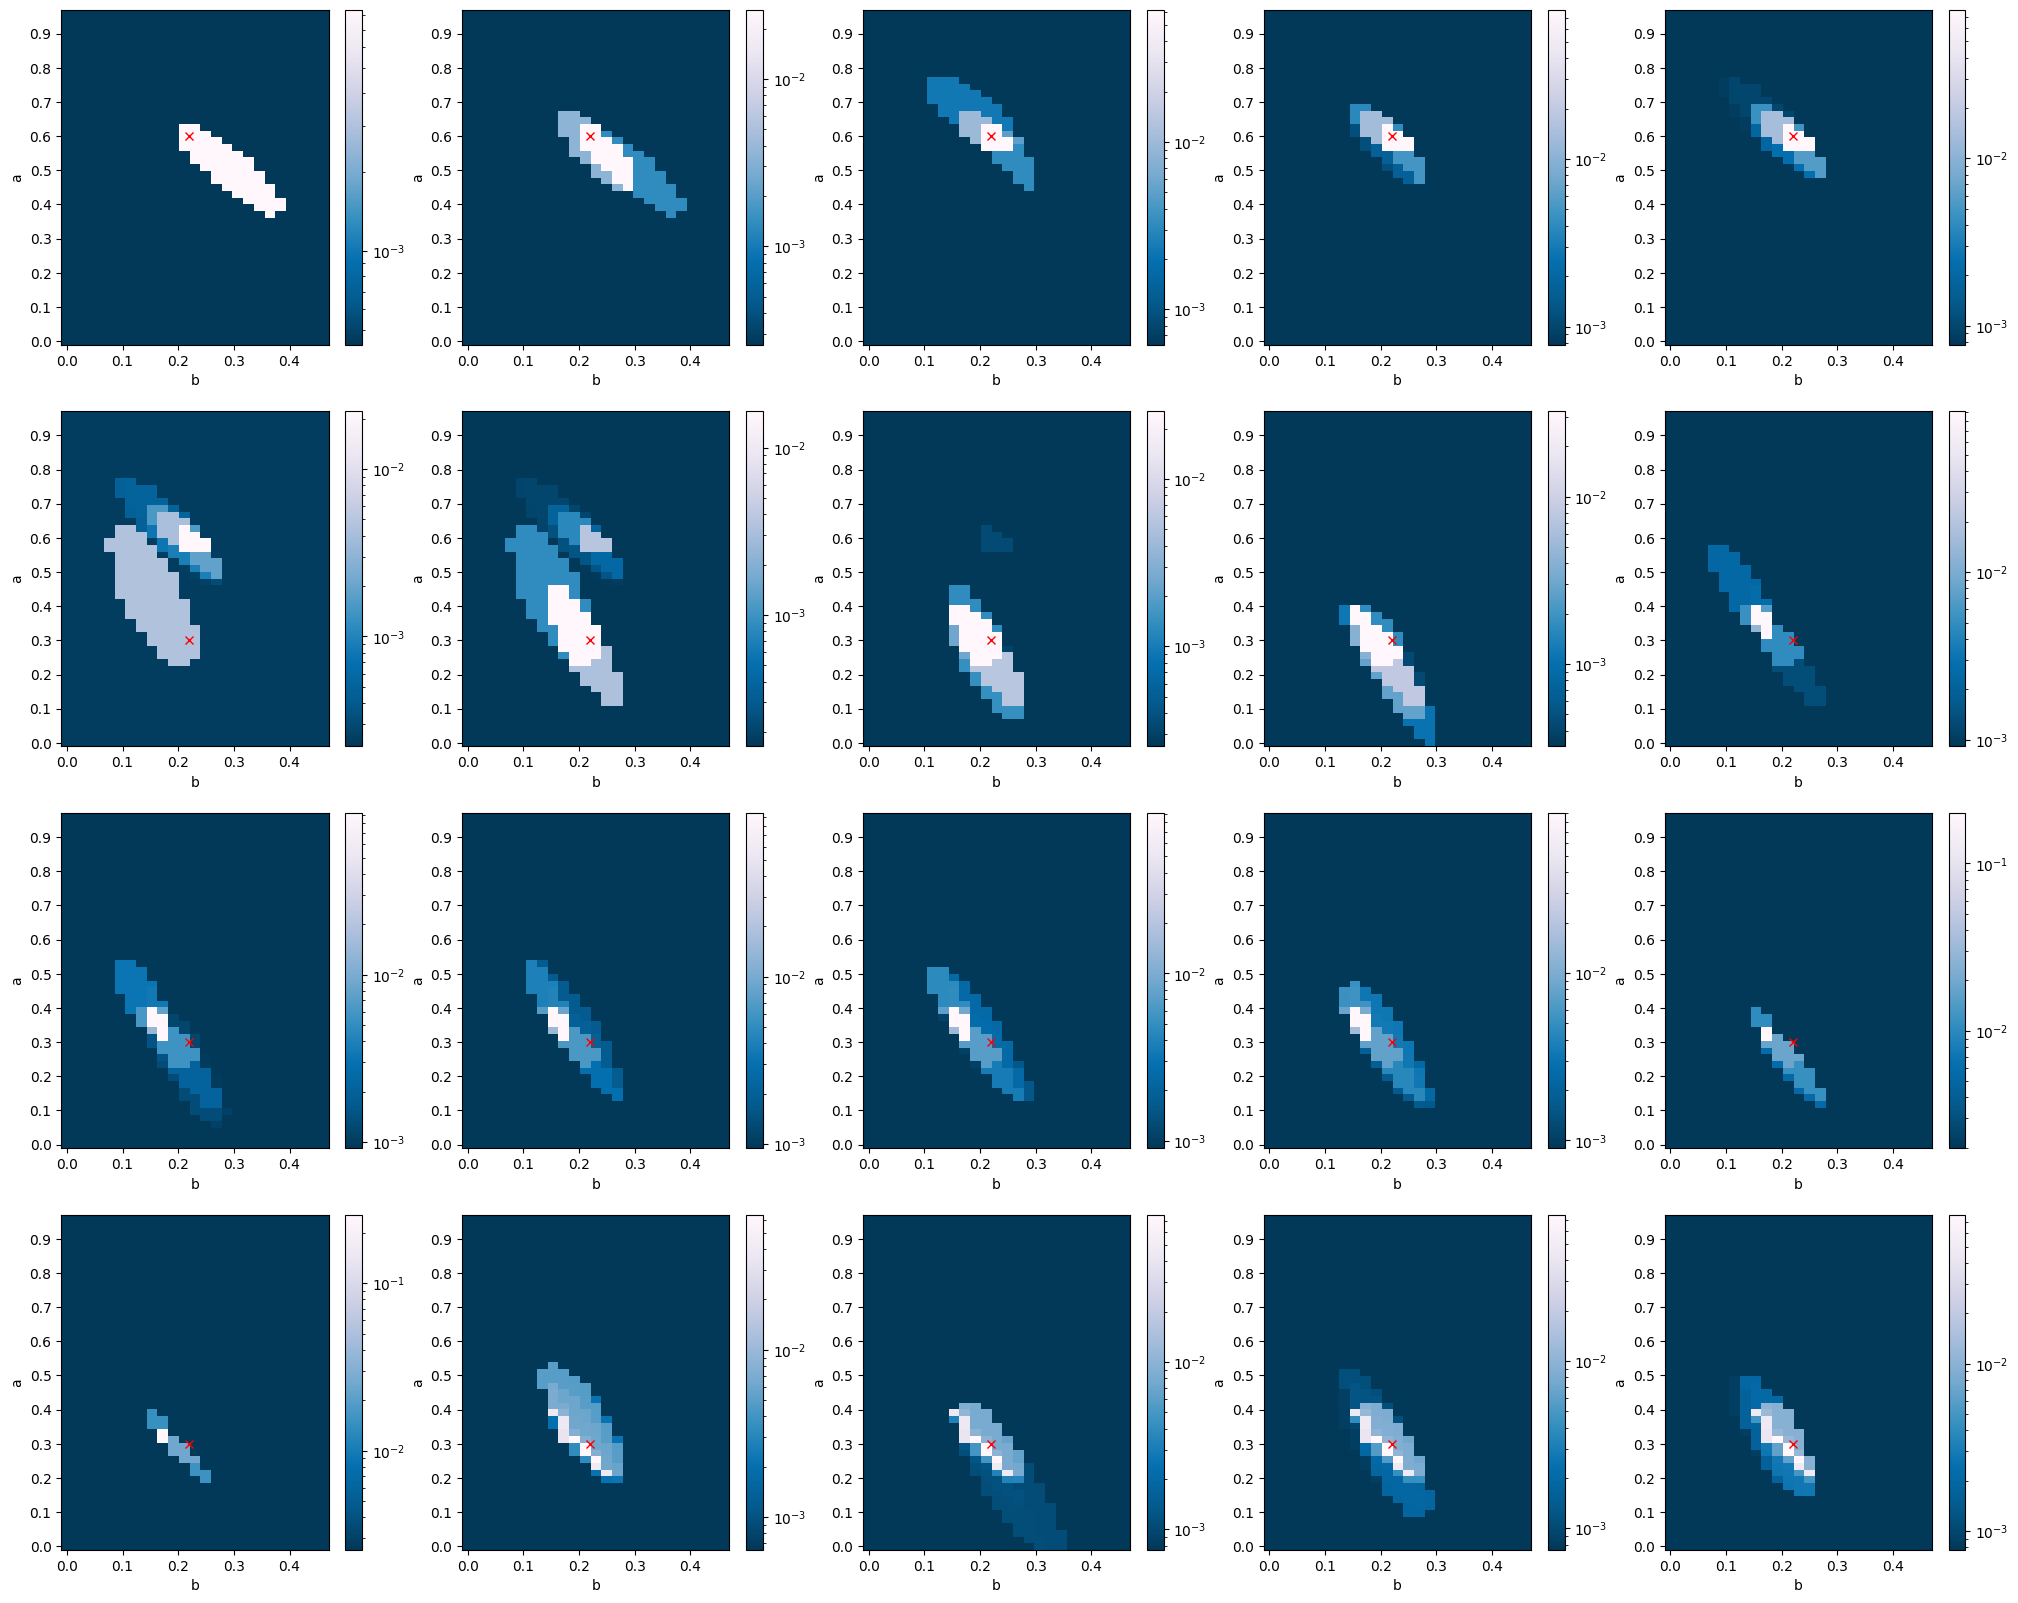

In [20]:
# ~~~~~~~~~~ generalised fusion

# https://en.wikipedia.org/wiki/Recursive_Bayesian_estimation#Model
#  - not sure how to theoretically justify the forgetting factor part


import matplotlib.colors as colors

a_grid, b_grid = cp.meshgrid(a_values, b_values, indexing='ij')

n_a = len(a_values)
n_b = len(b_values)

prior_0 = cp.ones((n_a,n_b)) * 0.05
for i in range(n_a):
    for j in range(n_b):
        a = a_grid[i][j]
        b = b_grid[i][j]
        if cp.any(cp.all(cp.isclose(results_vals[0], cp.array([a, b]), atol=1e-6), axis=1)):
            prior_0[i][j] = 0.95
prior_0 /= cp.sum(cp.abs(prior_0))

n_plots = n_iters
n_cols = 5
n_rows = int(cp.ceil(n_plots / n_cols))
a_offset = (a_values[1] - a_values[0]) * 0.5
b_offset = (b_values[1] - b_values[0]) * 0.5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
axes = axes.flatten()

ax = axes[0]
im = ax.imshow(prior_0, cmap="PuBu_r", origin="lower", norm=colors.LogNorm(vmin=cp.min(prior_0), vmax=cp.max(prior_0)), extent=[b_values[0] - b_offset, b_values[-1]- b_offset, a_values[0]- a_offset, a_values[-1]- a_offset])
ax.plot(0.22, a_vals[0], 'rx')  # Plot the true values as a red dot
ax.set_aspect('auto')
ax.set_xticks(b_values[::5])
ax.set_yticks(a_values[::5])
ax.set_xlabel('b')
ax.set_ylabel('a')
fig.colorbar(im, ax=ax)


forgetting_factor = 0.5       # 1 = disregard all past data, 0 = assume past data is always relevant (no change in plant over time)
for idx in range(1,n_plots):
    # posterior from last iteration is this iteration's prior
    if idx == 1:
        prior = prior_0.copy()
    else:
        prior = posterior.copy()

    # get the new_info grid
    new_info = cp.ones((n_a,n_b)) * 0.05
    for i in range(n_a):
        for j in range(n_b):
            a = a_grid[i][j]
            b = b_grid[i][j]
            # Check if the current gridpoint (a, b) is in the confidence region, update new_info
            if cp.any(cp.all(cp.isclose(results_vals[idx], cp.array([a, b]), atol=1e-6), axis=1)):
                new_info[i][j] = 0.95
    
    # update the posterior with this new info
    prior = cp.mean(prior) * cp.ones((n_a,n_b)) * forgetting_factor + prior * (1-forgetting_factor)
    posterior = cp.multiply(prior, new_info) # Hadamard product
    posterior /= cp.sum(cp.abs(posterior)) # normalisation

    ax = axes[idx]
    im = ax.imshow(posterior, cmap="PuBu_r", origin="lower", norm=colors.LogNorm(vmin=cp.max(posterior)/100, vmax=cp.max(posterior)), extent=[b_values[0] - b_offset, b_values[-1]- b_offset, a_values[0]- a_offset, a_values[-1]- a_offset])
    ax.plot(0.22, a_vals[idx], 'rx')  # Plot the true values as a red dot
    ax.set_aspect('auto')
    ax.set_xticks(b_values[::5])
    ax.set_yticks(a_values[::5])
    ax.set_xlabel('b')
    ax.set_ylabel('a')
    fig.colorbar(im, ax=ax)

In [21]:
# todo: use fusion at each iteration to get the confidence-region-so-far, and run min-max optimisation with this confidence region


In [22]:
# # ~~~~~~~~~~ simple 3x3 fusion

# results_vals = [cp.array([[0.6,0.2],[0.5,0.2],[0.6,0.3]]),
#                 cp.array([[0.5,0.2],[0.5,0.3],[0.6,0.3]])]

# a_range = cp.arange(0.5, 0.8, 0.1)
# b_range = cp.arange(0.1, 0.4, 0.1)

# a_grid, b_grid = cp.meshgrid(a_range, b_range, indexing='ij')

# prior = cp.ones((3,3)) * 0.05
# new_info = cp.ones((3,3)) * 0.05
# epsilon = 1e-6
# for i in range(3):
#     for j in range(3):
#         a = a_grid[i][j]
#         b = b_grid[i][j]
        
#         # Check if the current gridpoint (a, b) is in the confidence region, update prior
#         if cp.any(cp.all(cp.isclose(results_vals[0], cp.array([a, b]), atol=epsilon), axis=1)):
#             prior[i][j] = 0.95
#             # print(a,b)

#         if cp.any(cp.all(cp.isclose(results_vals[1], cp.array([a, b]), atol=epsilon), axis=1)):
#             new_info[i][j] = 0.95
#             # print("posterior",a,b)

# prior /= cp.sum(cp.abs(prior))
# posterior = cp.multiply(prior,new_info)
# posterior /= cp.sum(cp.abs(posterior))

# plt.figure()
# plt.imshow(prior, cmap="Greens", origin="lower", extent=[b_range[0] - 0.05, b_range[-1]- 0.05, a_range[0]- 0.05, a_range[-1]- 0.05])
# plt.xticks(b_range)
# plt.yticks(a_range)
# plt.colorbar()
# plt.show()

# plt.figure()
# plt.imshow(new_info, cmap="Greens", origin="lower", extent=[b_range[0] - 0.05, b_range[-1]- 0.05, a_range[0]- 0.05, a_range[-1]- 0.05])
# plt.xticks(b_range)
# plt.yticks(a_range)
# plt.colorbar()
# plt.show()

# plt.figure()
# plt.imshow(posterior, cmap="Greens", origin="lower", extent=[b_range[0] - 0.05, b_range[-1]- 0.05, a_range[0]- 0.05, a_range[-1]- 0.05])
# plt.xticks(b_range)
# plt.yticks(a_range)
# plt.colorbar()
# plt.show()

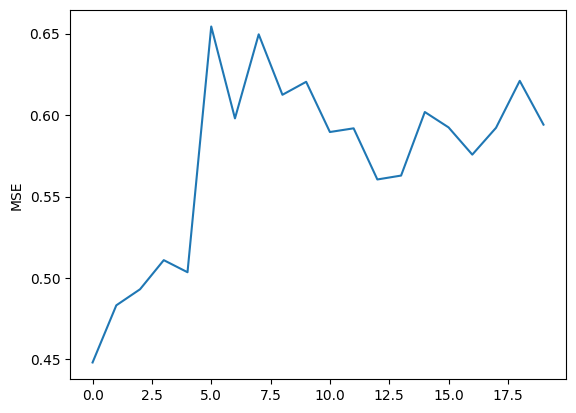

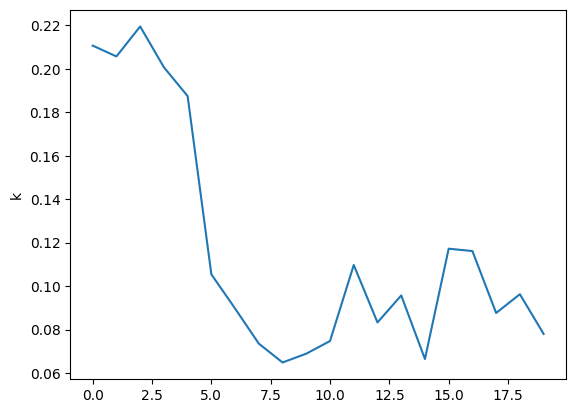

In [23]:
plt.figure()
plt.plot(cp.arange(n_iters), MSE_vals)
plt.ylabel('MSE')
plt.show()

plt.figure()
plt.plot(cp.arange(n_iters), k_vals)
plt.ylabel('k')
plt.show()